# Creación de un mapa de contaminación

Se pretende cargar la posición de las estaciones de medición de contaminantes junto con sus contaminantes y realizar una interpolación de estos contaminantes en todo un mallado entre las estaciones conocidas.

In [14]:
import numpy as np
import pandas as pd
import re
from scipy.interpolate import SmoothBivariateSpline
import matplotlib.pyplot as plt 

In [15]:
def dms2dd(input):
    "Esta función tranforma un punto expresado en coordenadas geográficas a coordenadas UTM"
    degrees,minutes,seconds,direction=re.split('[º\´"]+',str(input))
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

Se leeran las coordenadas de las estaciones y se filtrarán las que son de nuestro interés

In [16]:
posicion_estaciones=pd.read_excel('./data/EstacionesLocalizacion.xlsx') #Se carga el fichero

Se filtra el fichero de estaciones a la estaciones de nuestro estudio

In [17]:
Estacion=[4,8,11,35,38,39,47,48,49,50]
posicion_estaciones=posicion_estaciones[posicion_estaciones['Estacion'].isin(Estacion)]
posicion_estaciones.set_index('Estacion',inplace=True)
posicion_estaciones

,Columna1,Latitud,Longitud
Estacion,,,
47,Mendez Alavaro,"40º23´53.17""N","3º41´12.57""O"
11,Av Ramon y Cajal,"40º27´5.29""N","3º40´38.5""O"
8,Escuelas Aguirre,"40º25´17.63""N","3º40´56.22""O"
49,Retiro,"40º24´52""N","3º40´57.3""O"
50,Plaza Castilla,"40º27´56.1""N","3º41´19.48""O"
48,Paseo Castellana,"40º26´23.61""N","3º41´25.34""O"
35,Plaza del carmen,"40º25´9.15""N","3º42´11.4""O"
38,Cuatro Caminos,"40º26´43.97""N","3º42´25.64""O"
39,Barrio del pilar,"40º28´41.64""N","3º42´41.53""O"


Se convertirán los valores de Latitud y Longitud en coordenadas decimales

In [18]:
posicion_estaciones[['Latitud','Longitud']]=posicion_estaciones[['Latitud','Longitud']].applymap(lambda x: dms2dd(x))

In [19]:
posicion_estaciones.sort_values(['Latitud','Longitud'])

,Columna1,Latitud,Longitud
Estacion,,,
47,Mendez Alavaro,40.398103,3.686825
49,Retiro,40.414444,3.682583
35,Plaza del carmen,40.419208,3.703167
8,Escuelas Aguirre,40.421564,3.682283
4,Plaza de España,40.423883,3.712197
48,Paseo Castellana,40.439892,3.690372
38,Cuatro Caminos,40.445547,3.707122
11,Av Ramon y Cajal,40.451469,3.677361
50,Plaza Castilla,40.465583,3.688744


In [20]:
sortLatitud=posicion_estaciones['Latitud'].sort_values()
sortLongitud=posicion_estaciones['Longitud'].sort_values()

Se desea obtener una matriz de puntos sobre la que realizar una interpolación. La interpolación se realizará sobre los puntos conocidos, para obtener una matriz de valores contaminantes, que representará la polución en cada espacio geografico de Madrid capital

In [21]:
Latitudes=[]
Longitudes=[]
for i in range(0,(len(sortLatitud))):
    if i==9:
        lastLat=np.round(sortLatitud.iloc[i],decimals=6)
        lastLon=np.round(sortLongitud.iloc[i],decimals=6)
        Latitudes.append(lastLat)
        Longitudes.append(lastLon)
    else:
        inicioLat=sortLatitud.iloc[i]
        inicioLon=sortLongitud.iloc[i]
        finLat=sortLatitud.iloc[i+1]
        finLon=sortLongitud.iloc[i+1]
        betweenLat=np.round(np.arange(inicioLat,finLat,0.001),decimals=6)
        betweenLon=np.round(np.arange(inicioLon,finLon,0.001),decimals=6)
        Latitudes.extend(betweenLat)
        Longitudes.extend(betweenLon)

In [22]:
datos_estaciones=pd.read_csv('./data/NO2_estaciones.csv')
datos_estaciones.head()

,FECHA,Estacion4,Estacion8,Estacion11,Estacion35,Estacion38,Estacion39,Estacion47,Estacion48,Estacion49,Estacion50
0,2015-01-01 01:00:00,83.0,168.0,93.0,109.0,102.0,104.0,112.0,108.0,136.0,127.0
1,2015-01-01 02:00:00,77.0,203.0,224.0,133.0,183.0,168.0,120.0,114.0,111.0,170.0
2,2015-01-01 03:00:00,86.0,220.0,152.0,126.0,193.0,203.0,109.0,141.0,109.0,118.0
3,2015-01-01 04:00:00,65.0,169.0,151.0,112.0,122.0,147.0,87.0,145.0,99.0,126.0
4,2015-01-01 05:00:00,53.0,154.0,106.0,109.0,97.0,159.0,76.0,142.0,103.0,140.0


In [23]:
fecha=list(datos_estaciones.FECHA)

In [24]:
ix1 = pd.MultiIndex.from_product([fecha,Latitudes])

In [25]:
mapa = pd.DataFrame(index=ix1, columns=Longitudes, dtype=np.float64)

In [26]:
#for date in fechas 
date='2015-01-01 01:00:00'
x=[]
y=[]
Z=[]
for i in Estacion:
    lat=posicion_estaciones.loc[i,'Latitud'].round(decimals=6)
    print(lat)
    lon=posicion_estaciones.loc[i,'Longitud'].round(decimals=6)
    print(lon)
    Est='Estacion'+str(i)
    sust=float(datos_estaciones[datos_estaciones['FECHA']==date][Est])
    #mapa.loc[(date,lat),lon]=sust
    x.append(lon)
    y.append(lat)
    Z.append(sust)
    
interp_spline = SmoothBivariateSpline(y,x,Z,kx=2,ky=2)
mapa.loc[(date),:] = interp_spline(Latitudes,Longitudes)


40.423883
3.712197
40.421564
3.682283
40.451469
3.677361
40.419208
3.703167
40.445547
3.707122
40.478233
3.711536
40.398103
3.686825
40.439892
3.690372
40.414444
3.682583
40.465583
3.688744


/anaconda3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:1057: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


In [27]:
mapa.loc[(date),:]

,3.677361,3.678361,3.679361,3.680361,3.681361,3.682283,3.682583,3.683583,3.684583,3.685583,...,3.704167,3.705167,3.706167,3.707122,3.708122,3.709122,3.710122,3.711122,3.711536,3.712197
40.398103,-293.644680,-238.900828,-186.867096,-137.543483,-90.929990,-50.353629,-37.647673,2.943934,40.825422,75.996791,...,236.448774,218.545161,197.931428,175.715383,149.803367,121.181231,89.848975,55.806600,40.919810,16.188417
40.399103,-262.389387,-211.464238,-163.070264,-117.207466,-73.875843,-36.166815,-24.361031,13.346320,48.522495,81.167494,...,227.232686,210.307144,190.850425,169.906375,145.501209,118.564867,89.097349,57.098656,43.110327,19.877009
40.400103,-232.051208,-184.835471,-139.976999,-97.475792,-57.331850,-22.407771,-11.476274,23.429825,55.978660,86.170230,...,218.288210,202.315105,183.984735,164.278696,141.339874,116.043786,88.390434,58.379817,45.265455,23.489317
40.401103,-202.630143,-159.014528,-117.587301,-78.348462,-41.298010,-9.076497,1.006595,33.194451,63.193918,91.004998,...,209.615344,194.569044,177.334358,158.832345,137.319361,113.617990,87.728231,59.650084,47.385195,27.025341
40.402103,-174.126191,-134.001409,-95.901171,-59.825475,-25.774324,3.827008,13.087579,42.640196,70.168269,95.671799,...,201.214089,187.068962,170.899293,153.567322,133.439671,111.287476,87.110738,60.909456,49.469546,30.485080
40.403103,-146.539353,-109.796113,-74.918607,-41.906832,-10.760790,16.302743,24.766676,51.767061,76.901712,100.170632,...,193.084444,179.814859,164.679541,148.483628,129.700803,109.052246,86.537956,62.157934,51.518509,33.868536
40.404103,-119.869629,-86.398642,-54.639610,-24.592532,3.742590,28.350708,36.043887,60.575045,83.394249,104.501497,...,185.226411,172.806734,158.675102,143.581262,126.102758,106.912300,86.009886,63.395517,53.532083,37.175706
40.405103,-94.117018,-63.808993,-35.064180,-7.882576,17.735816,39.970904,46.919211,69.064150,89.645878,108.664395,...,177.639988,166.044587,152.885975,138.860225,122.645536,104.867637,85.526527,64.622206,55.510268,40.406593
40.406103,-69.281521,-42.027169,-16.192316,8.223036,31.218890,51.163330,57.392650,77.234374,95.656599,112.659325,...,170.325177,159.528419,147.312162,134.320515,119.329136,102.918257,85.087878,65.838000,57.453065,43.561195
40.407103,-45.363138,-21.053168,1.975980,23.724306,44.191810,61.927986,67.464201,85.085719,101.426414,116.486287,...,163.281976,153.258229,141.953661,129.962134,116.153559,101.064161,84.693941,67.042899,59.360474,46.639512


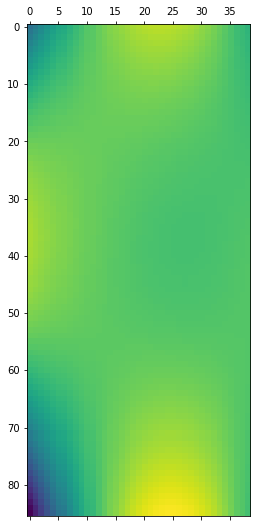

In [28]:
plt.matshow(mapa.loc[(date),:])
plt.show()

Para poder pasar los datos generados a una versión ordenada, que según Hadley Wickham, deberá realizar un "melt"

In [ ]:
mapa.stack().reset_index()